In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
SR=22050
N_MFCC=40
N_MELS=128
DURATION=1
SAMPLES_PER_TRACK=SR*DURATION
CLASSES=['AR','Sniper','nogun']

In [3]:
dataset = pd.read_csv('dataset1.csv')

In [4]:


# def extract_mfcc(audio_path, n_mfcc=13):
#     y, sr = librosa.load(audio_path)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
#     return np.mean(mfcc, axis=1) 

def extract_features(file_path):
    y,sr=librosa.load(file_path,sr=SR,duration=DURATION)
    if len(y)<SAMPLES_PER_TRACK:
        y=np.pad(y,(0,SAMPLES_PER_TRACK-len(y)))
    else:
        y=y[:SAMPLES_PER_TRACK]
    mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=N_MFCC)
    mfcc=librosa.util.fix_length(mfcc,size=174,axis=1)
    mfcc=mfcc[...,np.newaxis]

    mel_spec=librosa.feature.melspectrogram(y=y,sr=sr)
    mel_spec=librosa.power_to_db(mel_spec,ref=np.max)
    # plt.figure(figsize=(10,6))
    # librosa.display.specshow(mel_spec,sr=SR,x_axis='time',y_axis='mel')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Mel-Spectogram')
    # plt.tight_layout()
    # plt.show()
    mel_spec=librosa.util.fix_length(mel_spec,size=174,axis=1)
    mel_spec=mel_spec[...,np.newaxis]
    return mfcc,mel_spec


# audio_features_melspec = []
# audio_features_mfcc=[]

# for audio_file in os.listdir(audio_dir):
#     if audio_file.endswith('.wav'):
#         audio_path = os.path.join(audio_dir, audio_file)
#         mfcc_features,melspec_features = extract_features(audio_path)
#         audio_features_mfcc.append([audio_file] + mfcc_features.tolist())
#         audio_features_melspec.append([audio_file]+melspec_features.tolist())



In [5]:
def load_dataset(dataset_path):
    x_mfcc,x_melspec,gun_type,direction,distance=[],[],[],[],[]
    suffixes=['_gain.wav','_pan.wav','_pitch.wav','_reverse.wav','_speed.wav','_noise.wav','_original.wav']
    for i,class_name in enumerate(CLASSES):
        class_dir=os.path.join(dataset_path,class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path=os.path.join(class_dir,file_name)
                mfcc,mel_spec=extract_features(file_path)
                x_mfcc.append(mfcc)
                x_melspec.append(mel_spec)
                if class_name=='Sniper':
                    for suffix in suffixes:
                        if file_name.endswith(suffix):
                            file_name=file_name[:-len(suffix)]+'.wav'
                gun_type.append(i)
                if class_name=='nogun':
                    direction.append('None')
                    distance.append('None')
                else:
                    row=dataset[dataset['name']==file_name]
                    direction.append(row['dire'].values[0])
                    distance.append(row['dist'].values[0])
    x_mfcc=np.array(x_mfcc)
    x_melspec=np.array(x_melspec)
    gun_encoder=LabelEncoder()
    gun_types_encoded=gun_encoder.fit_transform(gun_type)
    gun_types_categorical=to_categorical(gun_types_encoded)
    gun_types_categorical=np.array(gun_types_categorical)
    direction_encoder=LabelEncoder()
    direction_types_encoded=direction_encoder.fit_transform(direction)
    direction_types_categorical=to_categorical(direction_types_encoded)
    direction_types_categorical=np.array(direction_types_categorical)
    distance_encoder=LabelEncoder()
    distance_types_encoded=distance_encoder.fit_transform(distance)
    distance_types_categorical=to_categorical(distance_types_encoded)
    distance_types_categorical=np.array(distance_types_categorical)
    return x_mfcc,x_melspec,gun_types_categorical,direction_types_categorical,distance_types_categorical


In [6]:
X_mfcc,X_melspec,y_gun,y_direction,y_distance=load_dataset('gun_sound_v9')

In [7]:
X_melspec_shape=X_melspec.shape
X_melspec_shape

(2807, 128, 174, 1)

In [8]:
X_mfcc_shape=X_mfcc.shape
X_mfcc_shape

(2807, 40, 174, 1)

In [9]:
y_gun.shape

(2807, 3)

In [10]:
y_direction.shape

(2807, 6)

In [11]:
X_mfcc_train, X_mfcc_test, X_melspec_train, X_melspec_test, y_gun_train, y_gun_test,y_distance_train,y_distance_test,y_direction_train,y_direction_test = train_test_split(
    X_mfcc, X_melspec, y_gun,y_distance,y_direction,test_size=0.3, random_state=42
)

# Then, split the training+validation set into training and validation sets
# X_mfcc_train, X_mfcc_val, X_melspec_train, X_melspec_val, y_gun_train, y_gun_val,y_distance_train,y_distance_val,y_direction_train,y_direction_val = train_test_split(
#     X_mfcc_trainval, X_melspec_trainval, y_gun_trainval,y_distance_trainval,y_direction_trainval, test_size=0.3, random_state=42
# )

In [12]:
y_gun_train=np.array(y_gun_train)
y_gun_train.shape

(1964, 3)

In [13]:
X_mfcc_test.shape

(843, 40, 174, 1)

In [14]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense,Input
from tensorflow.keras.models import Model
def create_model(input_shape_mfcc,input_shape_melspec,num_classes=3,num_directions=6,num_distances=7):
    input_mfcc=Input(shape=input_shape_mfcc,name='mfcc_input')
    x_mfcc=Conv2D(16,kernel_size=(3,3),activation='relu')(input_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(32,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(64,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(1,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)
    
    x_mfcc=Conv2D(128,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)
    
    x_mfcc=GlobalAveragePooling2D()(x_mfcc)

    input_melspec=Input(shape=input_shape_melspec,name='melspec_input')
    x_melspec=Conv2D(16,kernel_size=(3,3),activation='relu')(input_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(32,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(64,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(128,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec = GlobalAveragePooling2D()(x_melspec)

    concatenated=tf.keras.layers.concatenate([x_mfcc,x_melspec])
    common_dense=Dense(128,activation='relu',name='concatenated')(concatenated)
    gunshot_output=Dense(num_classes,activation='softmax',name='gunshot_output')(common_dense)
    direction_output=Dense(num_directions,activation='softmax',name='direction_output')(common_dense)
    distance_output=Dense(num_distances,activation='softmax',name='distance_output')(common_dense)

    model=Model(inputs=[input_mfcc,input_melspec],outputs=[gunshot_output,direction_output,distance_output])
    
    return model

In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

def create_feature_extractor(input_shape_mfcc, input_shape_melspec):
    model = create_model(input_shape_mfcc, input_shape_melspec)
    feature_extractor = Model(inputs=model.inputs, outputs=model.get_layer('concatenated').output)
    return model,feature_extractor

In [16]:
input_shape_mfcc=(40,174,1)
input_shape_melspec=(128,174,1)
model,feature_extractor=create_feature_extractor(input_shape_mfcc,input_shape_melspec)

In [17]:
model.compile(optimizer='adam',
              loss={
                    'gunshot_output':'categorical_crossentropy',
                    'direction_output':'categorical_crossentropy',
                    'distance_output':'categorical_crossentropy'},
                metrics={
                    'gunshot_output': ['accuracy', 'Precision', 'Recall', AUC()],
                    'distance_output': ['accuracy', 'Precision', 'Recall', AUC()],
                    'direction_output': ['accuracy', 'Precision', 'Recall', AUC()]
                    })
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input          │ (None, 40, 174,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ melspec_input       │ (None, 128, 174,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 172,   │        160 │ mfcc_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 172,  │        160 │ melspec_input[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 86,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 86,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 19, 86,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 63, 86,    │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 17, 84,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 84,    │      4,640 │ dropout_4[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 42, 32) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 42,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 42, 32) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 42,    │          0 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 40, 64) │     18,496 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 40,    │     18,496 │ dropout_5[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 20, 64) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 229,264 (895.56 KB)

 Trainable params: 229,264 (895.56 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from keras.callbacks import ModelCheckpoint
batch_size=32
valid_batch_size=32
callbacks=[ModelCheckpoint("best_model.keras",monitor='val_loss')]
history=model.fit([X_mfcc_train,X_melspec_train],
                  {
                      'gunshot_output':y_gun_train,
                      'direction_output':y_direction_train,
                      'distance_output':y_distance_train
                  },
                  validation_data=([X_mfcc_test,X_melspec_test],
                                    {
                                        'gunshot_output':y_gun_test,
                                        'direction_output':y_direction_test,
                                        'distance_output':y_distance_test
                                    }),
                    epochs=64,batch_size=32,callbacks=[callbacks])


Epoch 1/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 378ms/step - direction_output_Precision: 0.2988 - direction_output_Recall: 0.0435 - direction_output_accuracy: 0.2292 - direction_output_auc_2: 0.5705 - distance_output_Precision: 0.4854 - distance_output_Recall: 0.0319 - distance_output_accuracy: 0.2032 - distance_output_auc_1: 0.5726 - gunshot_output_Precision: 0.5849 - gunshot_output_Recall: 0.3057 - gunshot_output_accuracy: 0.5370 - gunshot_output_auc: 0.7021 - loss: 5.2059 - val_direction_output_Precision: 1.0000 - val_direction_output_Recall: 0.0380 - val_direction_output_accuracy: 0.3298 - val_direction_output_auc_2: 0.7410 - val_distance_output_Precision: 1.0000 - val_distance_output_Recall: 0.0368 - val_distance_output_accuracy: 0.2871 - val_distance_output_auc_1: 0.7513 - val_gunshot_output_Precision: 0.9708 - val_gunshot_output_Recall: 0.3155 - val_gunshot_output_accuracy: 0.7734 - val_gunshot_output_auc: 0.8783 - val_loss: 4.1261
Epoch 2/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step 

In [19]:
features=feature_extractor.predict([X_mfcc,X_melspec])

88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step


In [20]:
features

array([[4.171715 , 0.       , 0.       , ..., 0.       , 0.       ,
        1.0032145],
       [0.9501079, 0.       , 0.       , ..., 0.       , 0.       ,
        4.0702844],
       [1.6646764, 0.       , 0.       , ..., 0.       , 0.       ,
        2.177473 ],
       ...,
       [2.7272909, 0.       , 0.       , ..., 3.2492442, 0.       ,
        0.       ],
       [2.7257638, 0.       , 0.       , ..., 3.2485101, 0.       ,
        0.       ],
       [3.9788685, 1.5863292, 0.       , ..., 2.7371933, 0.       ,
        0.       ]], dtype=float32)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)  
features_reduced = pca.fit_transform(features)

In [22]:
# layer_name='concatenated'
# intermediate_layer_model=Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
# intermediate_layer_model.summary()

In [23]:
features.shape

(2807, 128)

In [24]:
y_gun.shape

(2807, 3)

In [22]:
y_combined = np.column_stack((y_gun, y_direction, y_distance))
X_train,X_test,y_train_combined,y_test_combined=train_test_split(features_reduced,y_combined,test_size=0.3)

y_gun_train_onehot = y_train_combined[:, :3]
y_gun_test_onehot = y_test_combined[:, :3]
y_gun_train = np.argmax(y_gun_train_onehot, axis=1)
y_gun_test = np.argmax(y_gun_test_onehot, axis=1)

y_dir_train_onehot = y_train_combined[:,[3,4,5,6,7,8]]
y_dir_test_onehot = y_test_combined[:,[3,4,5,6,7,8]]
y_dir_train = np.argmax(y_dir_train_onehot, axis=1)
y_dir_test = np.argmax(y_dir_test_onehot, axis=1)

y_dist_train_onehot = y_train_combined[:,[9,10,11,12,13,14,15]]
y_dist_test_onehot = y_test_combined[:,[9,10,11,12,13,14,15]]
y_dist_train = np.argmax(y_dist_train_onehot, axis=1)
y_dist_test = np.argmax(y_dist_test_onehot, axis=1)

In [23]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Stratified K-Fold for class balance in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective_function_gun(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_gun_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [24]:
def objective_function_dir(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_dir_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [25]:
def objective_function_dist(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_dist_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [26]:
param_ranges = [(50, 500),
                (3, 12),
                (0.01, 0.3),
                (0.5, 1.0),
                (0.5, 1.0),
                (0, 10)
]


In [27]:
%pip install pyswarm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
from pyswarm import pso
ans_gun,score = pso(objective_function_gun, lb=[b[0] for b in param_ranges], ub=[b[1] for b in param_ranges], swarmsize=10, maxiter=20)
ans_dir,score = pso(objective_function_dir, lb=[b[0] for b in param_ranges], ub=[b[1] for b in param_ranges], swarmsize=10, maxiter=20)
ans_dist,score = pso(objective_function_dist, lb=[b[0] for b in param_ranges], ub=[b[1] for b in param_ranges], swarmsize=10, maxiter=20)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:00:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:00:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:00:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Stopping search: maximum iterations reached --> 20


c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:35:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Stopping search: maximum iterations reached --> 20


c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:20:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Stopping search: maximum iterations reached --> 20


In [30]:
ans_gun

array([4.00306870e+02, 1.20000000e+01, 1.43519902e-01, 5.77698633e-01,
       5.04692678e-01, 0.00000000e+00])

In [31]:
import xgboost as xgb
xgb_model_gun=xgb.XGBClassifier(
        n_estimators=int(ans_gun[0]),
        max_depth=int(ans_gun[1]),
        learning_rate=ans_gun[2],
        subsample=ans_gun[3],
        colsample_bytree=ans_gun[4],
        gamma=ans_gun[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
xgb_model_gun.fit(X_train,y_gun_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:53:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.504692678497364, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14351990225297617,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [32]:
xgb_model_direction = xgb.XGBClassifier(
        n_estimators=int(ans_dir[0]),
        max_depth=int(ans_dir[1]),
        learning_rate=ans_dir[2],
        subsample=ans_dir[3],
        colsample_bytree=ans_dir[4],
        gamma=ans_dir[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
xgb_model_direction.fit(X_train, y_dir_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:53:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7992403470567245, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21076281021842685,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=213, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [33]:
xgb_model_distance = xgb.XGBClassifier(
        n_estimators=int(ans_dist[0]),
        max_depth=int(ans_dist[1]),
        learning_rate=ans_dist[2],
        subsample=ans_dist[3],
        colsample_bytree=ans_dist[4],
        gamma=ans_dist[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
xgb_model_distance.fit(X_train, y_dist_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:53:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7084431164124958, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10515927003654474,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=165, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [34]:
gun_type_pred=xgb_model_gun.predict(X_test)
direction_type_pred = xgb_model_direction.predict(X_test)
distance_type_pred = xgb_model_distance.predict(X_test)

In [35]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy for gun type
gun_accuracy = accuracy_score(y_gun_test, gun_type_pred)
print(f"Accuracy for gun type classification: {gun_accuracy * 100:.2f}%")

# Evaluate accuracy for direction type
direction_accuracy = accuracy_score(y_dir_test, direction_type_pred)
print(f"Accuracy for direction type classification: {direction_accuracy * 100:.2f}%")

# Evaluate accuracy for distance type
distance_accuracy = accuracy_score(y_dist_test, distance_type_pred)
print(f"Accuracy for distance type classification: {distance_accuracy * 100:.2f}%")


Accuracy for gun type classification: 99.41%
Accuracy for direction type classification: 88.14%
Accuracy for distance type classification: 97.27%


In [36]:
from sklearn.metrics import classification_report

# Gun type classification report
print("Gun Type Classification Report")
print(classification_report(y_gun_test, gun_type_pred))

# Direction type classification report
print("Direction Type Classification Report")
print(classification_report(y_dir_test, direction_type_pred))

# Distance type classification report
print("Distance Type Classification Report")
print(classification_report(y_dist_test, distance_type_pred))


Gun Type Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       358
           1       1.00      0.99      0.99       323
           2       0.99      0.99      0.99       162

    accuracy                           0.99       843
   macro avg       0.99      0.99      0.99       843
weighted avg       0.99      0.99      0.99       843

Direction Type Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       162
           1       0.82      0.94      0.88       141
           2       0.98      1.00      0.99       132
           3       0.90      0.83      0.86       127
           4       0.82      0.76      0.79       147
           5       0.76      0.77      0.77       134

    accuracy                           0.88       843
   macro avg       0.88      0.88      0.88       843
weighted avg       0.88      0.88      0.88       843

Distance

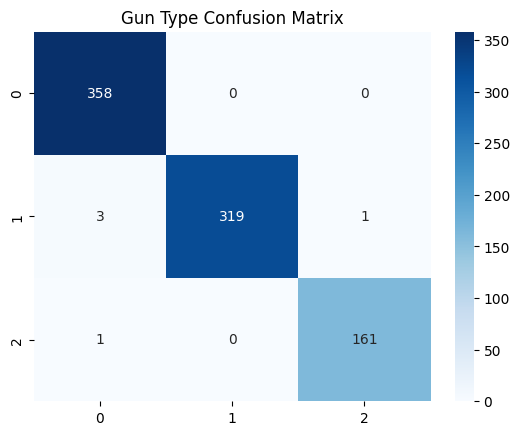

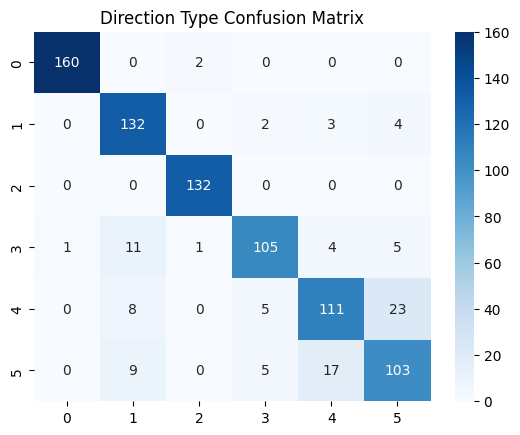

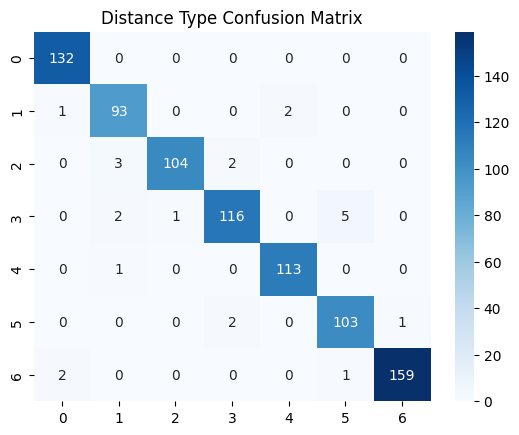

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for gun type classification
cm_gun = confusion_matrix(y_gun_test, gun_type_pred)
sns.heatmap(cm_gun, annot=True, fmt='d', cmap='Blues')
plt.title("Gun Type Confusion Matrix")
plt.show()

# Confusion matrix for direction type classification
cm_direction = confusion_matrix(y_dir_test, direction_type_pred)
sns.heatmap(cm_direction, annot=True, fmt='d', cmap='Blues')
plt.title("Direction Type Confusion Matrix")
plt.show()

# Confusion matrix for distance type classification
cm_distance = confusion_matrix(y_dist_test, distance_type_pred)
sns.heatmap(cm_distance, annot=True, fmt='d', cmap='Blues')
plt.title("Distance Type Confusion Matrix")
plt.show()


In [47]:
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gunshot_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gunshot_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gunshot feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [48]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['direction_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_direction_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for direction feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [49]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['distance_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_distance_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for distance feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model.keras',monitor='val_gunshot_output_accuracy',save_best_only=True,mode='max')
# history=model.fit([X_mfcc_train,X_melspec_train],
#                   {
#                       'gunshot_output':y_gun_train,
#                       'direction_output':y_direction_train,
#                       'distance_output':y_distance_train
#                   },
#                   validation_data=([X_mfcc_val,X_melspec_val],
#                                     {
#                                         'gunshot_output':y_gun_val,
#                                         'direction_output':y_direction_val,
#                                         'distance_output':y_distance_val
#                                     }),
#                     epochs=30,batch_size=32,callbacks=[checkpoint])
# model = create_model(input_shape_mfcc, input_shape_melspec)
# model=tf.keras.models.load_model('best_model.keras')
# model.load_weights('best_model.keras')
# results=model.evaluate([X_mfcc_test,X_melspec_test],{
#                                         'gunshot_output':y_gun_test,
#                                         'direction_output':y_direction_test,
#                                         'distance_output':y_distance_test
#                                     })
# test_loss=results[0]
# test_gun_accuracy=results[1]
# test_direction_accuracy=results[2]
# test_distance_accuracy=results[3]

# # print(f'Test Accuracy:{test_accuracy*100:.2f}%')
# # print(f'Test Loss:{test_loss*100:.2f}%')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model1.csv', index=False)